# Training models for searching

Using TF-IDF as well as unsupervised learning to categorize the given data we want to evaluate how good these solutions offer themelfs as search engines.

In [1]:
#imports
import os
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from xml.dom import minidom
import matplotlib.pyplot as plt
import itertools

In [2]:
data_path = "data/ie1_collection.trec"
search_path = "data/ie1_queries.trec"
data_doc = minidom.parse(data_path)
query_doc = minidom.parse(search_path)

In [3]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [4]:
def getText(nodelist):
    rc = []
    for node in nodelist:
        if node.nodeType == node.TEXT_NODE:
            rc.append(node.data)
    return ''.join(rc)

#Parses data into a dictionary where the key is the recordId and the value is the text
data_dictionary = {}
query_dictionary = {}


doclist = data_doc.getElementsByTagName('DOC')
querylist = query_doc.getElementsByTagName('DOC')
for doc in doclist:
    recordId = getText(doc.getElementsByTagName("recordId")[0].childNodes)
    text = getText(doc.getElementsByTagName("text")[0].childNodes)
    data_dictionary[recordId] = text

for query in querylist:
    recordId = getText(query.getElementsByTagName("recordId")[0].childNodes)
    text = getText(query.getElementsByTagName("text")[0].childNodes)
    query_dictionary[recordId] = text

print('length data_dictionary ' + str(len(data_dictionary)))
print('length query_dictionary ' + str(len(query_dictionary)))



length data_dictionary 20636
length query_dictionary 50


Now we need to train our models on it.

In [5]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=4,stop_words='english', max_features=5000, ngram_range=(1,3))
tf = tf_vectorizer.fit_transform(data_dictionary.values())

#change this to define the amount of topics. More topics mean more granular segmentation, less means more clustering
n_topics = 10

lda = LatentDirichletAllocation(n_components = n_topics, random_state = 0)

transformed_tf = lda.fit_transform(tf)
tf_feature_names = tf_vectorizer.get_feature_names()



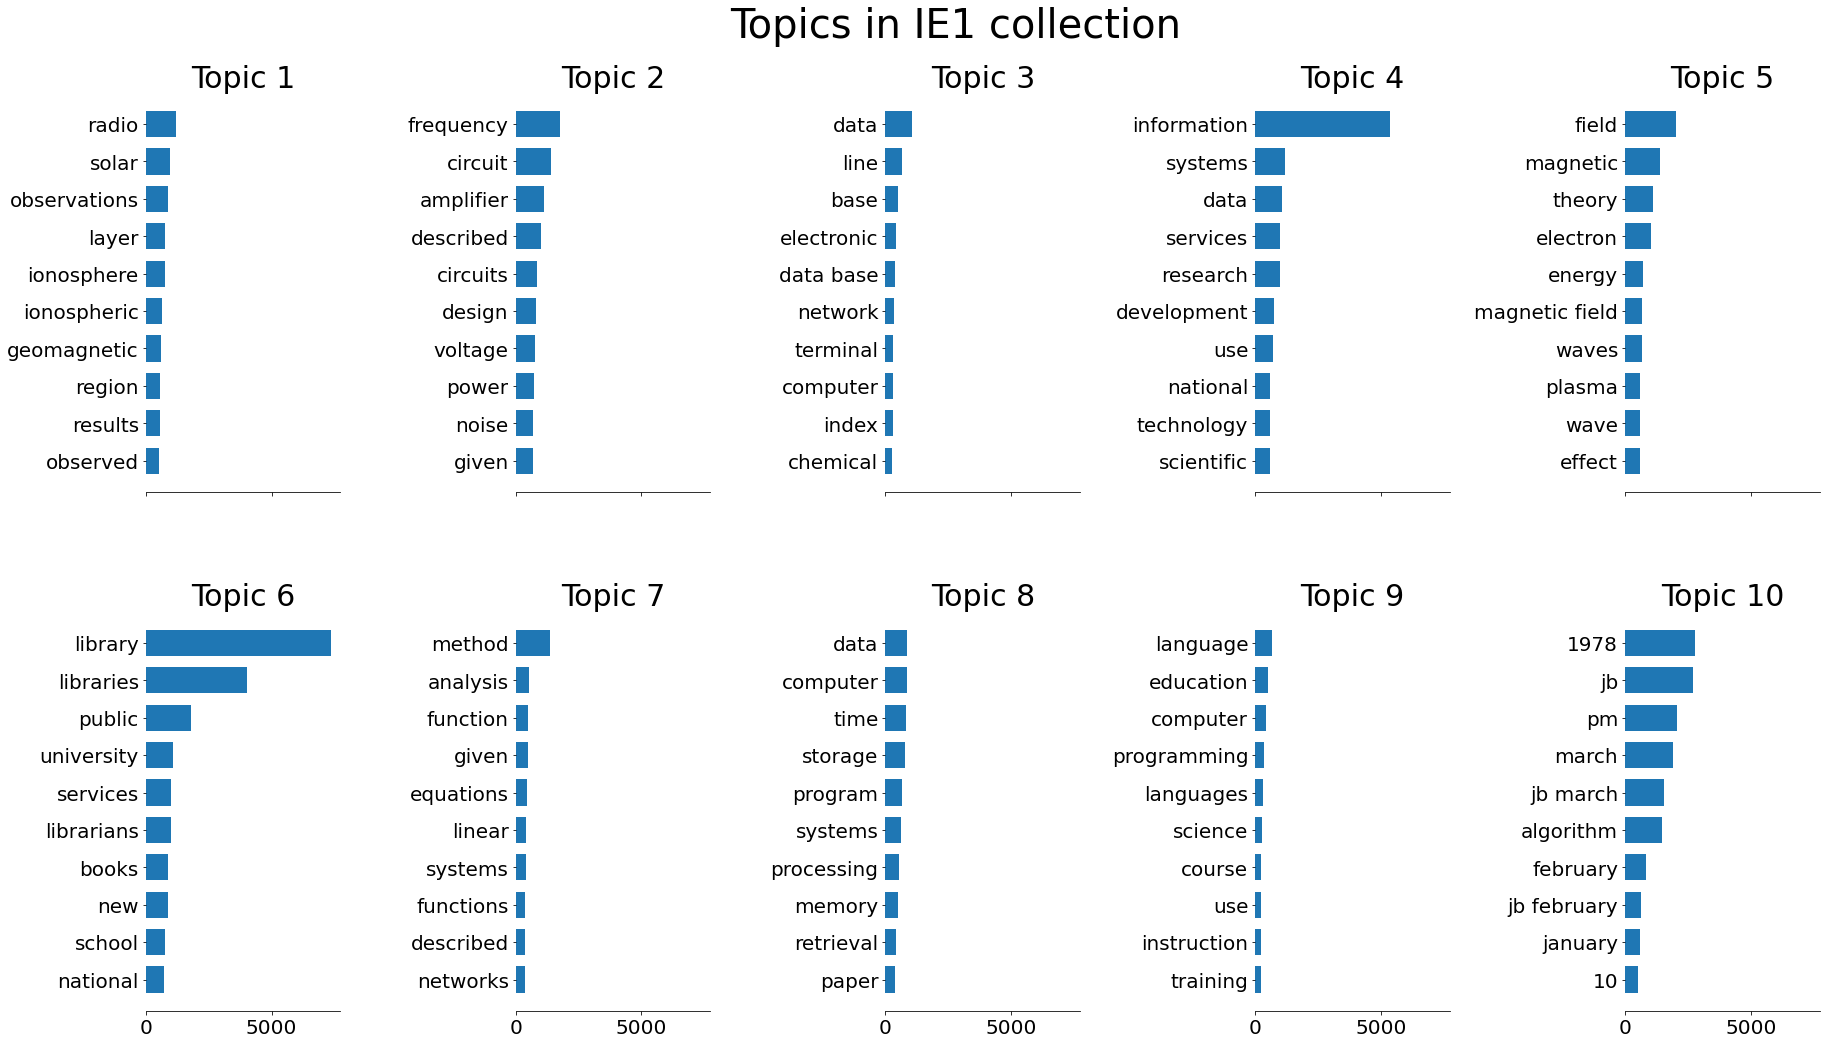

In [6]:
pred_topic = np.argmax(transformed_tf, axis=1)

plot_top_words(lda, tf_feature_names, n_topics, 'Topics in IE1 collection')

In [7]:
print(len(pred_topic))

20636


In [8]:
#Now we have to sort our data into the trained topics
data_topic_dictionary = {}
for index in pred_topic:
    if data_topic_dictionary.get(str(index)) is None:
        data_topic_dictionary[str(index)] = []

for index, value in enumerate(pred_topic):
    data_topic_dictionary[str(value)].append({"key": list(data_dictionary.keys())[index],
     "value": tf_vectorizer.transform([list(data_dictionary.values())[index]])})

        

Let's try adding topics to our search queries now

In [10]:
with open('/rankings.trec_eval', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ',)
    writer.writerow(['QueryID', 'Iteration', 'Dok.Nummer', 'Rang', 'Score', 'System'])
    for query_id, search_term in query_dictionary.items():
        #search_term = value
        #query_id= key
        tfst = tf_vectorizer.transform([search_term])
        topic = lda.transform(tfst)
        categorized_topic = topic.argmax()
        possible_documents = data_topic_dictionary[str(categorized_topic)]
        record_id = 0
        smallest_distance = 100000000000000000000000
        documents_with_distance = {}
        for document in possible_documents:
            distance = pairwise_distances(tfst, document['value']).tolist()[0][0]
            documents_with_distance[document['key']] = distance
        ordered_doc = sorted(documents_with_distance.items(), key=lambda x: x[1], reverse=True)
        rang = 1
        for od in ordered_doc:
            writer.writerow([query_id,'Q0', od[0], rang, od[1], 'group3'])
            rang += 1
            if rang == 51:
                break
    #slice_length = len(ordered_doc) if len(ordered_doc < 50) else 50
    #ordered_doc = dict(itertools.islice(ordered_doc.items(), slice_length))